In [1]:
import numpy as np
import pandas as pd
import glob


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline


rc = {'axes.facecolor': '#E3DCD1',
      'font.family': 'Lucida Sans Unicode',
      'grid.linestyle': '-',
      'grid.linewidth': '0.75',
      'grid.color': '#ffffff',
      'mathtext.fontset': 'stixsans',
      'mathtext.sf': 'sans',
      'legend.frameon': True}
plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans')
sns.set_style('darkgrid', rc=rc)
sns.set_palette("colorblind", color_codes=True)
sns.set(rc=rc)


## Outline for notebook

Following the work from Hwa (e.g. Scott et al. 2010), I'm curious to see how the fraction of ribosomal proteins varies as a function of growth rate in the Schmidt et al. data set and most importantly whether it is consistent with their data. In addition, there is useful data in the ribosomal profiling from Gene-Wei Li et al. 2015, and the older data from Taniguchi et al. 2010 that we can also consider.

Refs: 

Scott, M., Gunderson, C. W., Mateescu, E. M., Zhang, Z., & Hwa, T. (2010). 
Interdependence of cell growth and gene expression: origins and consequences. 
Science, 330(6007), 1099–1102. http://doi.org/10.1126/science.1192588

Li, G.-W., Burkhardt, D., Gross, C., & Weissman, J. S. (2014). Quantifying Absolute Protein Synthesis Rates Reveals Principles Underlying Allocation of Cellular Resources. Cell, 157(3), 624–635. http://doi.org/10.1016/j.cell.2014.02.033

Taniguchi, Y., Choi, P. J., Li, G.-W., Chen, H., Babu, M., Hearn, J., et al. (2010). Quantifying E. coli Proteome and Transcriptome with Single-Molecule Sensitivity in Single Cells. Science, 329(5991), 533–538. http://doi.org/10.1126/science.1188308

In [2]:
# Ribosome genes from Ecocyc:
ribsome_proteins = ['rplL', 'rpsA', 'rpsB', 'rpsC', 'rpsD', 'rpsE', 'rpsF', 'rpsG', 'rpsH', 'rpsI', 'rpsJ', 
                    'rpsK', 'rpsL', 'rpsM', 'rpsN', 'rpsO', 'rpsP', 'rpsQ', 'rpsR', 'rpsS', 'rpsT', 'rpsU', 
                    'sra', 'rrfA', 'rplA', 'rplB', 'rplC', 'rplD', 'rplE', 'rplF', 'rplJ',  
                    'rplI', 'rplK', 'rplM', 'rplN', 'rplO', 'rplP', 'rplQ', 'rplR', 'rplS', 'rplT', 'rplU', 
                    'rplV', 'rplW', 'rplX', 'rplY', 'rpmA', 'rpmB', 'rpmC', 'rpmD', 'rpmE', 'rpmF', 'rpmG', 
                    'rpmH', 'rpmI', 'rpmJ', 'rpsV']

# The 50S is noted to contain four subunits of rplL; otehrwise everything is in single subunits.
# Lets create a column with normalized values -for each subunit (i.e. correct for rplL)

## Load in the data

In [8]:
##############
# Begin with Schmidt et al
schmidt_df = pd.read_csv('../../data/schmidt2016_raw_data/schmidt2016_dataset.csv')
# schmidt_df[schmidt_df.dataset == 2]

schmidt_df_ribo = schmidt_df.loc[schmidt_df['gene'].isin(ribsome_proteins)]
schmidt_df_else = schmidt_df.loc[~schmidt_df['gene'].isin(ribsome_proteins)]
conditions_schmidt = schmidt_df_ribo.columns.unique()[11:33]

growthrates_df = pd.read_csv('../../data/schmidt2016_raw_data/schmidt2016_growth_rates.csv')
growthrates_df = growthrates_df[growthrates_df.strain=='BW25113']

growthrates_df = growthrates_df[['condition', 'dbl_time_hr','growth_rate_hr' ]]

##############
# Now Li et al
li_df = pd.read_csv('../../data/li2014_raw_data/Li_Cell_2014_tableS1.csv')

li_df_ribo = li_df.loc[li_df['Gene'].isin(ribsome_proteins)]
li_df_else = li_df.loc[~li_df['Gene'].isin(ribsome_proteins)]

# growthrates: 21.5 min doubling time in complete, 26.5 min in (-) L-Met, and 56.3 in minimal
# lambda = ln(2)/doubling time
growthrates_df = growthrates_df.append({'Growth condition': 'MOPS complete', 
           'Doubling time (h-1)':60/21.5,
           'Growth rate (h-1)':np.log(2)/21.5*60.0}, ignore_index=True)
growthrates_df = growthrates_df.append({'Growth condition': 'MOPS complete without methionine', 
           'Doubling time (h-1)':60/26.5,
           'Growth rate (h-1)':np.log(2)/26.5*60.0}, ignore_index=True)
growthrates_df = growthrates_df.append({'Growth condition': 'MOPS minimal', 
           'Doubling time (h-1)':60/56.3,
           'Growth rate (h-1)':np.log(2)/56.3*60.0}, ignore_index=True)

##############
# lastly taniguichi et al
# Cells were grown in LB media with 20 μg/ml Chloramphenicol and 
# subsequently were inoculated into M9 media supplemented with 0.4 % glucose, 
# amino acids and vitamin with 1:400 dilution. The cells were incubated at 30°C 
# for 11-12 hours and were grown to OD600 = 0.1-0.5.

# in SI they say ~150 minutes division time
taniguichi_df = pd.read_csv('../../../data/tanguichi_2010_Science_tableS6.csv')

taniguichi_df_ribo = taniguichi_df.loc[taniguichi_df['Gene Name'].isin(ribsome_proteins)]
taniguichi_df_else = taniguichi_df.loc[~taniguichi_df['Gene Name'].isin(ribsome_proteins)]
growthrates_df = growthrates_df.append({'Growth condition': 'minimal glucose_30C', 
           'Doubling time (h-1)':60.0/150,
           'Growth rate (h-1)':np.log(2)/150*60.0}, ignore_index=True)
# need to confirm taniguichi growth rate!

FileNotFoundError: [Errno 2] File b'../../data/schmidt2016_raw_data/schmidt2016_dataset.csv' does not exist: b'../../data/schmidt2016_raw_data/schmidt2016_dataset.csv'

In [4]:
# grab the data for each ribosomal subunit - this doesn't get them all; ignore.
# them all (there are a couple that must not contain '50S' or '30S' in description)
# schmidt_df_ribo_50S = schmidt_df[schmidt_df['Description'].str.contains("50S")]
# schmidt_df_ribo_30S = schmidt_df[schmidt_df['Description'].str.contains("30S")]

In [5]:
# #############
# # lets make a tidier DataFrame of all the data - (pretty slow)
# # for now we just care about the mean copy numbers
# combined_df = pd.DataFrame()
# ##############

# # Schmidt
# for gene, data in schmidt_df_ribo.groupby('Gene'):
#     for cond in conditions_schmidt:
#         data_list = {'Gene':gene, 'condition':cond[:-4], 'copy_number':data[cond].values[0], 
#                      'copy_number_stdev':data[cond].values[0]*data[cond[:-4]+'_cv'].values[0]/100,
#                      'type':'ribosomal', 'dataset':'Schmidt', 
#                      'growth_rate':growthrates_df[growthrates_df['Growth condition'] == \
#                                 cond[:-4]]['Growth rate (h-1)'].values[0],
#                     'Annotated functional COG groups (letter)':data['Annotated functional COG groups (letter)'].unique()[0],
#                     'Annotated functional COG group (description)':data['Annotated functional COG group (description)'].unique()[0],
#                     'Annotated functional COG class':data['Annotated functional COG class'].unique()[0]}    
#         combined_df = combined_df.append(data_list, ignore_index=True)

# for gene, data in schmidt_df_else.groupby('Gene'):
#     for cond in conditions_schmidt:
#         data_list = {'Gene':gene, 'condition':cond[:-4], 'copy_number':data[cond].values[0], 
#                      'copy_number_stdev':data[cond].values[0]*data[cond[:-4]+'_cv'].values[0]/100,
#                      'type':'non-ribosomal', 'dataset':'Schmidt', 
#                      'growth_rate':growthrates_df[growthrates_df['Growth condition'] == \
#                                 cond[:-4]]['Growth rate (h-1)'].values[0],
#                     'Annotated functional COG groups (letter)':data['Annotated functional COG groups (letter)'].unique()[0],
#                     'Annotated functional COG group (description)':data['Annotated functional COG group (description)'].unique()[0],
#                     'Annotated functional COG class':data['Annotated functional COG class'].unique()[0]}    
#         combined_df = combined_df.append(data_list, ignore_index=True)
        
# # Li
# for gene, data in li_df_ribo.groupby('Gene'):
#     for cond in li_df_ribo.columns[1:]:
#         data_list = {'Gene':gene, 'condition':cond, 'copy_number':data[cond].values[0], 
#                      'type':'ribosomal', 'dataset':'Li',
#                     'growth_rate':growthrates_df[growthrates_df['Growth condition'] == \
#                                                  cond]['Growth rate (h-1)'].values[0],
#                     'Annotated functional COG groups (letter)':schmidt_df[schmidt_df.Gene==gene]['Annotated functional COG groups (letter)'].unique()[0],
#                     'Annotated functional COG group (description)':schmidt_df[schmidt_df.Gene==gene]['Annotated functional COG group (description)'].unique()[0],
#                     'Annotated functional COG class':schmidt_df[schmidt_df.Gene==gene]['Annotated functional COG class'].unique()[0]}    
#         combined_df = combined_df.append(data_list, ignore_index=True)

# for gene, data in li_df_else.groupby('Gene'):
#     for cond in li_df_else.columns[1:]:
#         if schmidt_df[schmidt_df.Gene==gene].empty:
#             data_list = {'Gene':gene, 'condition':cond, 'copy_number':data[cond].values[0], 
#                      'type':'ribosomal', 'dataset':'Li',
#                     'growth_rate':growthrates_df[growthrates_df['Growth condition'] == \
#                                                  cond]['Growth rate (h-1)'].values[0]}
#             combined_df = combined_df.append(data_list, ignore_index=True)
#         else:
#             data_list = {'Gene':gene, 'condition':cond, 'copy_number':data[cond].values[0], 
#                          'type':'non-ribosomal', 'dataset':'Li',
#                         'growth_rate':growthrates_df[growthrates_df['Growth condition'] == \
#                                                      cond]['Growth rate (h-1)'].values[0],
#                         'Annotated functional COG groups (letter)':schmidt_df[schmidt_df.Gene==gene]['Annotated functional COG groups (letter)'].unique()[0],
#                         'Annotated functional COG group (description)':schmidt_df[schmidt_df.Gene==gene]['Annotated functional COG group (description)'].unique()[0],
#                         'Annotated functional COG class':schmidt_df[schmidt_df.Gene==gene]['Annotated functional COG class'].unique()[0]}        
#             combined_df = combined_df.append(data_list, ignore_index=True)
        
# # Taniguichi
# for gene, data in taniguichi_df_ribo.groupby('Gene Name'):
#     data_list = {'Gene':gene, 'condition':cond, 'copy_number':data['Mean_Protein'].values[0], 
#                  'copy_number_stdev':data['SD_Protein'].values[0],
#                  'type':'ribosomal', 'dataset':'Tanguichi',
#                  'growth_rate':growthrates_df[growthrates_df['Growth condition'] == \
#                                               'minimal glucose_30C']['Growth rate (h-1)'].values[0],
#                     'Annotated functional COG groups (letter)':schmidt_df[schmidt_df.Gene==gene]['Annotated functional COG groups (letter)'].unique()[0],
#                     'Annotated functional COG group (description)':schmidt_df[schmidt_df.Gene==gene]['Annotated functional COG group (description)'].unique()[0],
#                     'Annotated functional COG class':schmidt_df[schmidt_df.Gene==gene]['Annotated functional COG class'].unique()[0]}        
#     combined_df = combined_df.append(data_list, ignore_index=True)

# for gene, data in taniguichi_df_else.groupby('Gene Name'):
#     if schmidt_df[schmidt_df.Gene==gene].empty:
#         data_list = {'Gene':gene, 'condition':cond, 'copy_number':data['Mean_Protein'].values[0],
#                  'copy_number_stdev':data['SD_Protein'].values[0],
#                  'type':'non-ribosomal', 'dataset':'Tanguichi',
#                  'growth_rate':growthrates_df[growthrates_df['Growth condition'] == \
#                                               'minimal glucose_30C']['Growth rate (h-1)'].values[0]}
#         combined_df = combined_df.append(data_list, ignore_index=True)
#     else:
#         data_list = {'Gene':gene, 'condition':cond, 'copy_number':data['Mean_Protein'].values[0],
#                  'copy_number_stdev':data['SD_Protein'].values[0],
#                  'type':'non-ribosomal', 'dataset':'Tanguichi',
#                  'growth_rate':growthrates_df[growthrates_df['Growth condition'] == \
#                                               'minimal glucose_30C']['Growth rate (h-1)'].values[0],
#                     'Annotated functional COG groups (letter)':schmidt_df[schmidt_df.Gene==gene]['Annotated functional COG groups (letter)'].unique()[0],
#                     'Annotated functional COG group (description)':schmidt_df[schmidt_df.Gene==gene]['Annotated functional COG group (description)'].unique()[0],
#                     'Annotated functional COG class':schmidt_df[schmidt_df.Gene==gene]['Annotated functional COG class'].unique()[0]}           
#         combined_df = combined_df.append(data_list, ignore_index=True)

In [4]:
# combined_df.to_csv('../../../data/combined_copynumbers_Schmidt_Li_Tanguichi.csv')
combined_df = pd.read_csv('../../../data/combined_copynumbers_Schmidt_Li_Tanguichi.csv')

In [5]:
combined_df.head()

,Unnamed: 0,Annotated functional COG class,Annotated functional COG group (description),Annotated functional COG groups (letter),Gene,condition,copy_number,copy_number_stdev,dataset,growth_rate,type
0,0,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,Glucose,28502.0,4514.7168,Schmidt,0.58,ribosomal
1,1,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,LB,76877.0,1614.4170,Schmidt,1.90,ribosomal
2,2,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,Glycerol + AA,47366.0,587.3384,Schmidt,1.27,ribosomal
3,3,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,Acetate,11672.0,466.8800,Schmidt,0.30,ribosomal
4,4,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,Fumarate,17445.0,439.6140,Schmidt,0.42,ribosomal


## Plot Ribosomal Fraction vs. growth rate

Lets plot the ribosomal fraction as a function of growth rates across all the data

NB to do: I will outline the model used here. Also need to do sanity check on growth rates reported. (in progress)

This follows the work of Scott et al. 2010:

For exponentially growing E. coli cells, the RNA/protein ratio r is linearly correlated with the specific growth rate $\lambda$ ( = $ln 2$ /doubling time). 

$ r = r_0 + \frac{\lambda}{\kappa_t}$ 

where $r$ is the RNA/protein ratio, where $r_0$ is the vertical intercept and $\kappa_t$ is the inverse of the slope.

The simplest model connecting ribosome abundance to gene expression assumes that the 
total protein content of the cell (called the proteome) is composed of two classes: 
ribosome-affiliated “class R” proteins (with mass fraction fR), and “others” (with 
mass fraction 1 – fR) (5, 16). 





In [8]:
# lets also include the data from Scott et al. 2010 (including the additional historical data they use)
    
# linear regression line from Scott et al 2010
lambda_ = np.linspace(0,2.2)
r = 0.087 + (lambda_/ 4.5)

# r_schmidt = frac_ribo /0.76
# r_schmidt_err = frac_ribo_err /0.76

R_scott = np.array([0.177, 0.23, 0.224, 0.287, 0.414, 0.466])*0.76
lambda_scott = [0.4,0.57,0.71,1,1.31,1.58]

########################
# J. Forchhammer, L. Lindahl, J. Mol. Biol. 55, 563 (1971)
########################
# lambda x-axis, RNA/protein r ;
# 1.043026706231454, 0.29437031810919057
# 1.737388724035608, 0.4617169180967402
# 0.6023738872403561, 0.22544769770289064
# 0.370919881305638, 0.18889626693781003
# lambda x-axis, R protein r /total protein; 
R_forchhammer = [0.214, 0.343,0.161, 0.133, 0.143]
lambda_forchhammer = [1.043, 1.737, 0.602, 0.371, 0.415]

########################
# H. Bremer, P. P. Dennis, in Escherichia coli and Salmonella,
# F. C. Neidhardt, Ed. (ASM Press, Washington, DC, 1996),
# pp. 1553–1569.
########################
# lambda x-axis, RNA/protein r ;                                                                                
# 0.6913946587537092, 0.2558050258346995
# 1.043026706231454, 0.33108360482247734
# 1.3813056379821957, 0.3906372559191551
# 1.737388724035608, 0.4680106243904465
# lambda x-axis, R protein r /total protein;  
R_bremer = [0.185, 0.242, 0.288, 0.348]
lambda_bremer = [0.691, 1.043, 1.381, 1.737] 

Text(0.5, 0, 'growth rate $\\lambda$ (h$^{-1}$)')

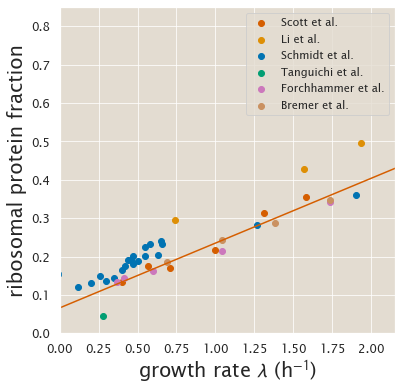

In [9]:
# plotting

# set color for each dataset
pal = sns.color_palette(palette='colorblind', n_colors=8)
colorlist = pal.as_hex()
datasets_arr = np.append(combined_df.dataset.unique(), ['Scott', 'Forchhammer', 'Bremer'])
color_dict = dict(zip(datasets_arr, colorlist))


fig, ax = plt.subplots(figsize=(6,6))

for cond, data in combined_df.groupby(['dataset', 'condition']):
    ribo_frac = data[data.type == 'ribosomal'].copy_number.sum() / data.copy_number.sum() 
    growth_rate = data.growth_rate.unique()
    ax.scatter(growth_rate, ribo_frac, label = cond[0] + ' et al.', color = color_dict[cond[0]])
    
ax.plot(lambda_, r*0.76, color = color_dict['Scott'], label='Scott et al.')
ax.scatter(lambda_scott, R_scott, color = color_dict['Scott'], label='Scott et al.')
ax.scatter(lambda_forchhammer, R_forchhammer, color = color_dict['Forchhammer'], label='Forchhammer et al.')
ax.scatter(lambda_bremer, R_bremer, color = color_dict['Bremer'], label='Bremer et al.')


plt.ylim(0,0.85)
plt.xlim(0,2.15)
plt.legend(fontsize=14)
plt.tick_params(which='major', labelsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.ylabel('ribosomal protein fraction', fontsize=20)
plt.xlabel('growth rate $\lambda$ (h$^{-1}$)', fontsize=20)
# plt.savefig('r-protein_fraction_schmidt_hwa_li_.pdf', bbox_inches='tight' )